# Introduction

The quantum Fourier transform and quantum phase estimation provide the foundation for many quantum algorithms, including the quantum matrix inversion, which is extensively used in quantum machine learning. It is therefore worthwhile developing a good understanding of these building blocks before moving on to more complex algorithms.

We must emphasize that starting with this notebook, the algorithms presented are **coherent quantum protocols**. By that, we mean that the **input and output of an algorithm is a quantum state** that we do not have classical information about. The protocol itself might use measurements: in this sense, they are not fully coherent, since we gain some, but incomplete classical information about the quantum system. We might also perform post-selection, which means that a gate is controlled by the classical output of a measurement. In some cases, we entirely discard a calculation based on a measurement output.

Why does it matter that we begin and end up with quantum states? Can't we just use state preparation starting from classical data and then perform tomography on the final state? We could do that, but **state preparation and tomography are resource-intensive and they are likely to destroy any quantum advantage**.

An additional problem is that the quantum Fourier transformation and other quantum algorithms similar in complexity require a very large number of gates on a large number of high-quality qubits. This is why the **practical relevance of these algorithms is not immediate**.

Nevertheless, since they are the core of many quantum machine learning protocols it is essential that we take a look at them.

In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer

π = np.pi

# Quantum Fourier Transform

The quantum Fourier transform is a quantum algorithm for the discrete Fourier transform over the amplitudes of a wavefunction. The exposition here follows the introduction in [[1](#1)]. A similar approach can be found in the [Qiskit tutorials](https://github.com/Qiskit/qiskit-tutorials/blob/master/community/algorithms/shor_algorithm.ipynb).

The **classical discrete Fourier transform** acts on a vector $\vec{x}=\begin{bmatrix}x_0\\ \vdots\\ x_{N-1}\end{bmatrix}$ and maps it to the vector $\vec{y}=\begin{bmatrix}y_0\\ \vdots\\ y_{N-1}\end{bmatrix}$, where $y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{ 2\pi i \frac{jk}{N}}$. 


The **quantum Fourier transform** acts on an amplitude-encoded variant of this vector, the quantum state $|x\rangle=\sum_{i=0}^{N-1} x_i |i \rangle$ and maps it to the quantum state $|y\rangle=\sum_{k=0}^{N-1} y_k |k \rangle$, where $y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{ 2\pi i \frac{jk}{N}}$. Since the transformed state is also in the superposition of the computational basis, in essence, only the amplitudes are transformed.


The quantum Fourier transform can be approximately implemented for any N. However, the implementation for the case where N is a power of 2 is much simpler.  To derive a circuit for $N=2^n$, consider the transform acts on the state 

$$| x \rangle = | x_1 \rangle \otimes \cdots \otimes |x_n \rangle = | x_1...x_n \rangle$$

where $x_1$ is the **most significant bit** (unlike the usual convention followed in the course) and $|x_j\rangle$ indicates that qubit $j$ is in state $x_j \in \{0,1\}$. We will rewrite a real number $x$ belonging to the unit interval in fractional binary notation as

$$x = \lfloor 0.x_1 \cdots x_n \rfloor = \sum_{k=1}^n \dfrac{x_k}{2^k}$$

The action of the unitary describing the QFT transform on a quantum state $|x\rangle$ can be expanded as

<img src="figures/qft.png" alt="qft" style="width: 800px;"/>

which can be expanded as:

<img src="figures/qft.2.png" alt="qft" style="width: 1200px;"/>

This expression as a decomposed tensor product state of $n$ single-qubit operations shows that only one qubit depends on the values of all the other input qubits.  The remaining qubits depend less and less on the input qubits. This simple structure allows us to design a quantum circuit based on Hadamard gates and rotations. 

In general the circuit can be represented as:

<img src="figures/qft.circuit.png" alt="qft" style="width: 800px;"/>

On three qubits, we can define the circuit as follows:

In [3]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')

qft = QuantumCircuit(q, c)

qft.h(q[0])
qft.cu1(π/2, q[1], q[0])
qft.h(q[1])
qft.cu1(π/4, q[2], q[0])
qft.cu1(π/2, q[2], q[1])
qft.h(q[2]);

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


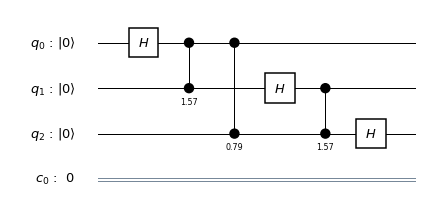

In [5]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qft)

# Quantum phase estimation

The goal of a quantum phase estimation algorithm is, given a unitary operator $U$ and an eigenvector $|\psi\rangle$ of $U$, to estimate $\theta$ in  $U|\psi \rangle =e^{2 i \pi \theta}|\psi \rangle$. Since $U$ is unitary, all of its eigenvalues have an absolute value of 1. By convention, $\theta$ is taken to be in $[0,1[$ and is called the *phase* of $U$ associated to $|\psi\rangle$

The eigenvector $|\psi\rangle$ is encoded in one set of quantum registers. An additional set of $n$ qubits forms an ancilla register. At the end of the procedure, this ancilla register should contain an approximation of the [binary fraction](https://www.electronics-tutorials.ws/binary/binary-fractions.html) associated to $\theta$, with n-bits precision. A critical element is the ability to perform the controlled unitary $C-U^{2^k}$ -- it is usually assumed to be provided to the phase estimation protocol.

First, the uniform superposition is prepared in the ancilla register via the application of Hadamard gates $H$. These qubits will act as controls for the unitary operators at different time steps. Our goal is to create a superposition of $U$ as the unitary is applied for different durations. Since the eigenvalues are always situated on the complex unit circle, these differently evolved components in the superposition help reveal the eigenstructure. Given the ancilla register we have a superposition of all possible time steps between $0$ and $2^{n-1}$, we will end up with a superposition of all possible evolutions to encode binary representations of the eigenvalues. At the end of this procedure, we have the state 

\begin{equation}
\frac {1}{2^{n/2}} \left( |0\rangle+{e^{2 i \pi \theta \cdot 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{2 i \pi \theta \cdot 2^{1}}}|1\rangle \right) \otimes \left(|0\rangle+{e^{2i \pi \theta \cdot 2^{0}}}|1\rangle \right) = \frac {1}{2^{n/2}}\sum _{k=0}^{2^{n}-1}e^{2 i \pi \theta k}|k\rangle
\end{equation}

in the ancilla. To write the ancilla in this form, we exploit that the controlled unitary operations when applied, introduce a global phase, and it is this global phase that we see in the ancilla. This phenomenon is also known as the **phase kickback**.

As a final step, we apply an inverse Fourier transform on the ancilla. Measuring out in the computational basis, we get the phase in the ancilla register:

\begin{align}
\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2i \pi \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} | \tilde{\theta} \rangle \otimes | \psi \rangle
\end{align}

where $\tilde{\theta}$ is the n-bits approximation of the binary fraction representing $\theta$.

The circuit for phase estimation is the following:

<img src="figures/phaseEstimation.png" alt="qft" style="width: 800px;"/>

## Toy example

As a toy example, let's take the $2\times 2$ unitary matrix $\begin{bmatrix}e^{0} & 0 \\0 & e^{i \pi}\end{bmatrix}=\begin{bmatrix}1 & 0 \\0 & -1\end{bmatrix}$, which has the eigenvectors $|0\rangle$ and $|1\rangle$, and phases

\begin{aligned}
\theta_0 &= 0 \\
\theta_1 &=\frac{1}{2}
\end{aligned}

Therefore, the $C-U^{2^k}$ gate is a controlled-$Z$ gate for $k$ even and the identity for $k$ odd.

## a) First eigenvector $|0\rangle$

Starting with $|\psi\rangle=|0\rangle$ in the main register, we prepare the superposition in the ancilla:

In [6]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1]);

In [7]:
# Controlled-U0
qpe.cz(q[1], q[2]);
# Controlled-U1
# nothing: identity

We apply quantum inverse Fourier transformation to write the phase to the ancilla register:

In [8]:
qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1]);

We will get the result from the two first registers

In [9]:
qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1]);

We can plot the circuit:

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


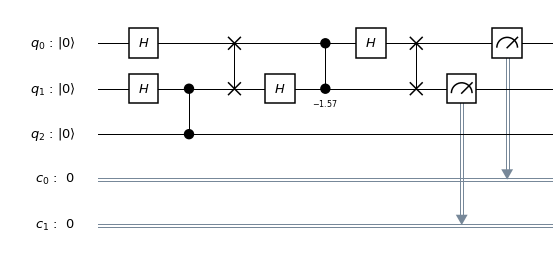

In [10]:
circuit_drawer(qpe)

Let's now test our circuit:

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'00': 1000}

As expected the result is $|2 \cdot \theta_0\rangle=|2\cdot 0\rangle=|00\rangle$

## b) Second eigenvector $|1\rangle$

In [13]:
qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1])
qpe.x(q[2]) # create |1> in the main register

qpe.cz(q[1], q[2])

qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(- π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1])

qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1]);

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'10': 1000}

The result should be $|10\rangle$. Indeed, $10 \rightarrow 1\cdot 2^{-1} + 0 \cdot 2^0=\frac{1}{2}=\theta_1$